# 1. Undersampling and Oversampling

In this notebook, I'll explore ways to help with our bad classifier predictions. While our accuracy was pretty high, our precision and recall weren't that good. As previously explained, this behaviour is expected because of our unbalanced dataset.

Some ways to help to prevent classifiers to generalise badly is to undersample and oversample our data and I'll explore what these concepts mean and how to use them properly.

Undersampling can be described as a way to reduce the imbalance in a dataset by removing data points from the classes that are in higher number in the dataset. Oversampling, meanwhile, is to produce more data points for the class that is in lower quantity in order to balance the dataset.

We can get a simplistic look at how it works here: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

I'll be using Sklearn's implementation of undersampling and oversampling techniques.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from imblearn import over_sampling, under_sampling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix, average_precision_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import fraudutils as futils
import warnings

warnings.filterwarnings(action='once')

%load_ext autoreload
%autoreload 2
%matplotlib inline

I'll be loading the same data as before, but now I'll split it into train and test while maintaining its distributuin and I'll apply oversampling and undersampling techniques and compare the results of simple ML algorithms, both in accuracy, precision and recall metrics.

After loading our dataset, I will be splitting it into train and test and then apply undersampling and oversampling techniques on the training set. This way we can use the new generated train set to train our algorithms and see how they perform on the test set.

In [2]:
cc_df = pd.read_csv('../../../data/raw/kaggle/creditcard.csv')
X_ = cc_df.drop(['Time', 'Class'], axis=1)
y_ = cc_df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=0, stratify=y_)

I'll be comparing classifiers before and after applying undersampling and oversampling as shown bellow.

The metrics used below are accuracy, precision and recall, these are defined as:

$$Accuracy = \dfrac{TruePositive + TrueNegative}{TruePositive + FalsePositive + TrueNegative + FalseNegative}$$

$$Precision = \dfrac{TruePositive}{TruePositive + FalsePositive}$$

$$Recall = \dfrac{TruePositive}{TruePositive + TrueNegative}$$

In this analysis I'll be considering fraudulent examples as positives and non-fraudulents as negatives.

With the previous data split, we should have:


In [3]:
print("Non-fraudulent: {}".format(len([x for x in y_test if x == 0])))
print("Fraudulent: {}".format(len([x for x in y_test if x == 1])))

Non-fraudulent: 56864
Fraudulent: 98


In [4]:
def classify(X_train, X_test, y_train, y_test, random_state=0, classifier=LogisticRegression, normalized=True):
    clf = classifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auprc = average_precision_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred)
    
    print("Mean accuracy: {}".format(accuracy))
    print("Mean precision: {}".format(precision))
    print("Mean recall: {}".format(recall))
    print("AUPRC: {}".format(auprc))
    print("AUROC: {}".format(auroc))
    
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    futils.plot_confusion_matrix(cm=cm, classes=['Not fraud', 'Fraud'], normalize=normalized)
    
    return {'accuracy': accuracy, 
            'precision': precision,
            'recall': recall,
            'AUPRC': auprc,
            'AUROC': auroc}

In [5]:
logistic_regression_scores = {}
decision_tree_scores = {}
naive_bayes_scores = {}
knn_scores = {}

## No sampling applied

Logistic regression results:
Mean accuracy: 0.9991748885221726
Mean precision: 0.8493150684931506
Mean recall: 0.6326530612244898
AUPRC: 0.5379537783071681
AUROC: 0.8162298086088685


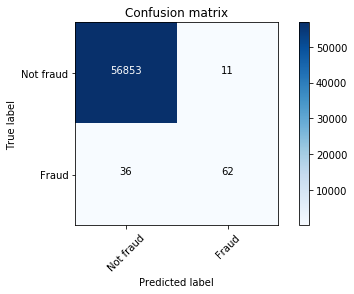

Decision tree results:
Mean accuracy: 0.9991397773954567
Mean precision: 0.7525773195876289
Mean recall: 0.7448979591836735
AUPRC: 0.5610321985726947
AUROC: 0.8722379497662881


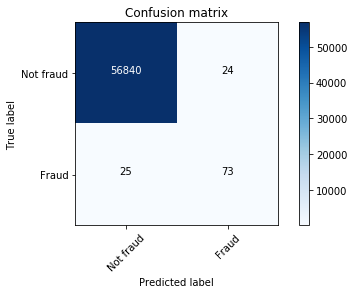

Naive Bayes results:
Mean accuracy: 0.9777571012253783
Mean precision: 0.06019563581640331
Mean recall: 0.8163265306122449
AUPRC: 0.04945529468444721
AUROC: 0.8971809214681934


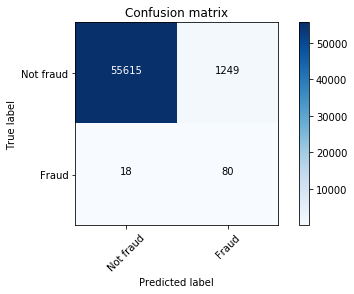

KNN results:
Mean accuracy: 0.9992275552122467
Mean precision: 0.9354838709677419
Mean recall: 0.5918367346938775
AUPRC: 0.5543559420866582
AUROC: 0.7958831957093474


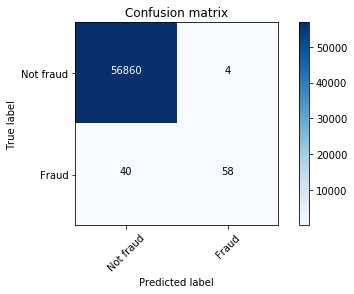

In [6]:
print("Logistic regression results:")
logistic_regression_scores['normal'] = classify(X_train, X_test, y_train, y_test, classifier=LogisticRegression, normalized=False)
print("Decision tree results:")
decision_tree_scores['normal'] = classify(X_train, X_test, y_train, y_test, classifier=DecisionTreeClassifier, normalized=False)
print("Naive Bayes results:")
naive_bayes_scores['normal'] = classify(X_train, X_test, y_train, y_test, classifier=GaussianNB, normalized=False)
print("KNN results:")
knn_scores['normal'] = classify(X_train, X_test, y_train, y_test, classifier=KNeighborsClassifier, normalized=False)

As expected, our classifiers had a high accuracy, however, we can see using confusion matrix that we're misclassifying 24 samples as fraud and overlooking 26 samples as not fraud. 

In our application, I'll assume that's more important to not mistake fraudulent samples with non-fraud than the other way around.

Bellow, I'll apply some oversampling and undersampling techniques and I'll compare them to see if we had any improvements.

## Oversampling: Random

In [7]:
ros = over_sampling.RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)

Logistic regression results:
Mean accuracy: 0.9780379902391068
Mean precision: 0.0649056603773585
Mean recall: 0.8775510204081632
AUPRC: 0.05716869525471298
AUROC: 0.9278810954601311


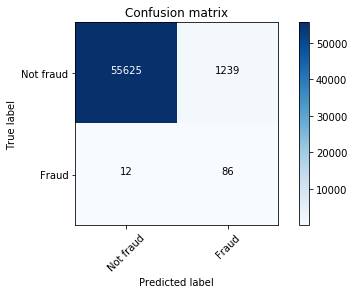

Decision tree results:
Mean accuracy: 0.9990871107053826
Mean precision: 0.7395833333333334
Mean recall: 0.7244897959183674
AUPRC: 0.5362945784419594
AUROC: 0.8620250752242372


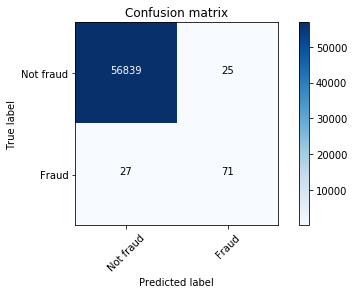

Naive Bayes results:
Mean accuracy: 0.9737368772163899
Mean precision: 0.051347881899871634
Mean recall: 0.8163265306122449
AUPRC: 0.04223263842605401
AUROC: 0.895167345216083


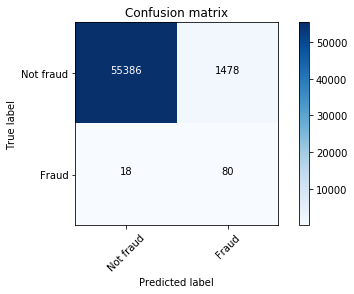

KNN results:
Mean accuracy: 0.9990344440153085
Mean precision: 0.7047619047619048
Mean recall: 0.7551020408163265
AUPRC: 0.5325884860959086
AUROC: 0.8772784402168295


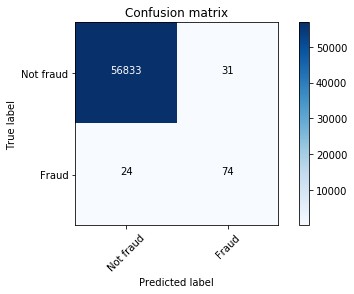

In [8]:
print("Logistic regression results:")
logistic_regression_scores['random_os'] = classify(X_oversampled,
                                                     X_test,
                                                     y_oversampled,
                                                     y_test,
                                                     classifier=LogisticRegression,
                                                     normalized=False)
print("Decision tree results:")
decision_tree_scores['random_os'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=DecisionTreeClassifier, normalized=False)
print("Naive Bayes results:")
naive_bayes_scores['random_os'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=GaussianNB, normalized=False)
print("KNN results:")
knn_scores['random_os'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=KNeighborsClassifier, normalized=False)

## Oversampling: SMOTE

In [9]:
smote = over_sampling.SMOTE(random_state=0)
X_oversampled, y_oversampled = smote.fit_sample(X_train, y_train)

Logistic regression results:
Mean accuracy: 0.9833222148098733
Mean precision: 0.083984375
Mean recall: 0.8775510204081632
AUPRC: 0.07391124073988817
AUROC: 0.9305277611888875


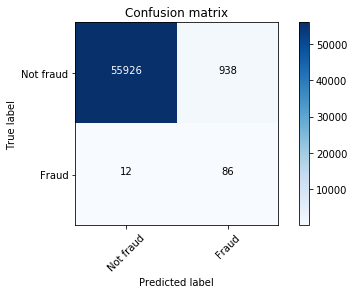

Decision tree results:
Mean accuracy: 0.9977002212000983
Mean precision: 0.41081081081081083
Mean recall: 0.7755102040816326
AUPRC: 0.3189741981247095
AUROC: 0.8867966749164494


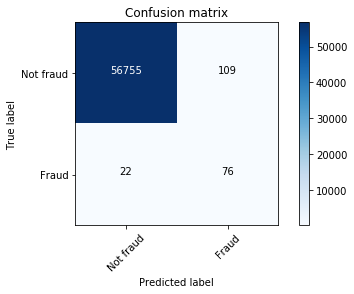

Naive Bayes results:
Mean accuracy: 0.9743513219339208
Mean precision: 0.05252790544977019
Mean recall: 0.8163265306122449
AUPRC: 0.04319592295658344
AUROC: 0.8954750970450083


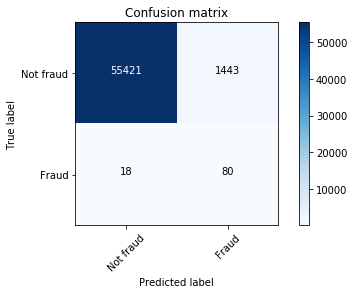

KNN results:
Mean accuracy: 0.9967697763421228
Mean precision: 0.32661290322580644
Mean recall: 0.826530612244898
AUPRC: 0.2702540074473959
AUROC: 0.911796890253006


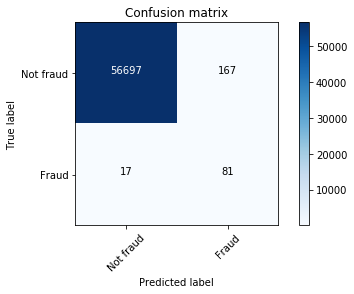

In [10]:
print("Logistic regression results:")
logistic_regression_scores['smote'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=LogisticRegression, normalized=False)
print("Decision tree results:")
decision_tree_scores['smote'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=DecisionTreeClassifier, normalized=False)
print("Naive Bayes results:")
naive_bayes_scores['smote'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=GaussianNB, normalized=False)
print("KNN results:")
knn_scores['smote'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=KNeighborsClassifier, normalized=False)


## Oversampling: ADASYN

In [11]:
adasyn = over_sampling.ADASYN(random_state=0)
X_oversampled, y_oversampled = adasyn.fit_sample(X_train, y_train)

Logistic regression results:
Mean accuracy: 0.9555317580141147
Mean precision: 0.03298810893747603
Mean recall: 0.8775510204081632
AUPRC: 0.029159415419714077
AUROC: 0.9166085856120725


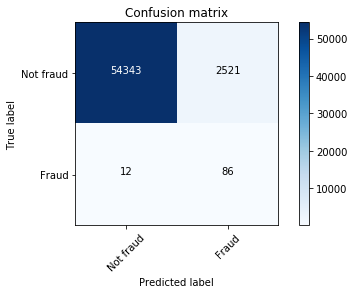

Decision tree results:
Mean accuracy: 0.9974193321863699
Mean precision: 0.3689839572192513
Mean recall: 0.7040816326530612
AUPRC: 0.26030393835910054
AUROC: 0.851003253017583


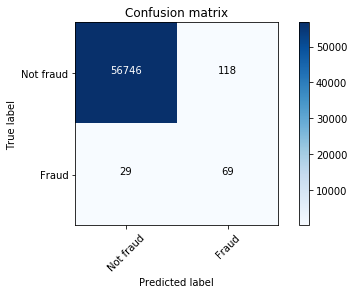

Naive Bayes results:
Mean accuracy: 0.9603419823742144
Mean precision: 0.035668242372152985
Mean recall: 0.8469387755102041
AUPRC: 0.03047215096964285
AUROC: 0.9037380990663008


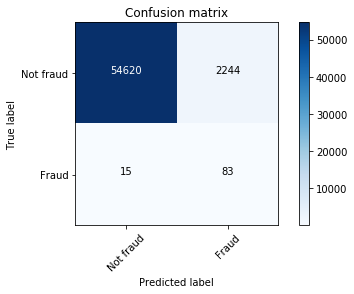

KNN results:
Mean accuracy: 0.9964011095116042
Mean precision: 0.30111524163568776
Mean recall: 0.826530612244898
AUPRC: 0.24917940960250187
AUROC: 0.9116122391556509


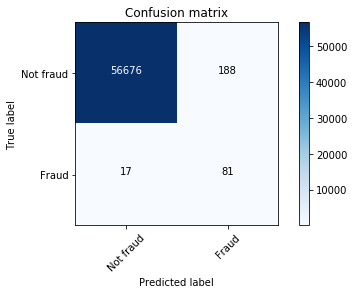

In [12]:
print("Logistic regression results:")
logistic_regression_scores['adasyn'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=LogisticRegression, normalized=False)
print("Decision tree results:")
decision_tree_scores['adasyn'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=DecisionTreeClassifier, normalized=False)
print("Naive Bayes results:")
naive_bayes_scores['adasyn'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=GaussianNB, normalized=False)
print("KNN results:")
knn_scores['adasyn'] = classify(X_oversampled, X_test, y_oversampled, y_test, classifier=KNeighborsClassifier, normalized=False)

## Undersampling: Random

In [13]:
rus = under_sampling.RandomUnderSampler(random_state=0)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)

Logistic regression results:
Mean accuracy: 0.9702784312348584
Mean precision: 0.04918032786885246
Mean recall: 0.8877551020408163
AUPRC: 0.043853198182552226
AUROC: 0.929087877413205


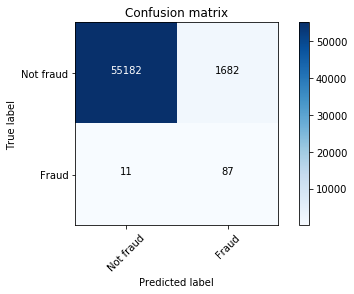

Decision tree results:
Mean accuracy: 0.9153119623608722
Mean precision: 0.017558187015108206
Mean recall: 0.8775510204081632
AUPRC: 0.015618871691921906
AUROC: 0.8964640301815718


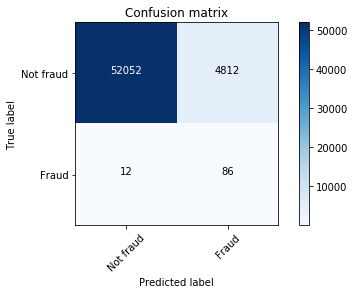

Naive Bayes results:
Mean accuracy: 0.9728590990484884
Mean precision: 0.05086848635235732
Mean recall: 0.8367346938775511
AUPRC: 0.04284431636978254
AUROC: 0.9049141955600474


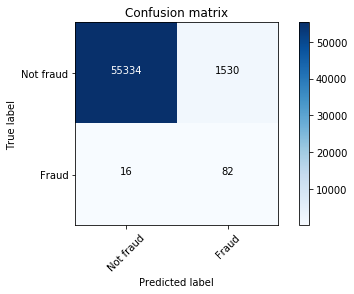

KNN results:
Mean accuracy: 0.933868192830308
Mean precision: 0.022390002603488675
Mean recall: 0.8775510204081632
AUPRC: 0.019859036391929256
AUROC: 0.9057581354151114


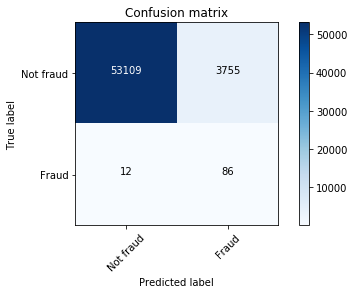

In [14]:
print("Logistic regression results:")
logistic_regression_scores['random_us'] = classify(X_undersampled, X_test, y_undersampled, y_test, classifier=LogisticRegression, normalized=False)
print("Decision tree results:")
decision_tree_scores['random_us'] = classify(X_undersampled, X_test, y_undersampled, y_test, classifier=DecisionTreeClassifier, normalized=False)
print("Naive Bayes results:")
naive_bayes_scores['random_us'] = classify(X_undersampled, X_test, y_undersampled, y_test, classifier=GaussianNB, normalized=False)
print("KNN results:")
knn_scores['random_us'] = classify(X_undersampled, X_test, y_undersampled, y_test, classifier=KNeighborsClassifier, normalized=False)

## Scores

### Logistic regression scores

In [15]:
logistic_regression_df = pd.DataFrame(logistic_regression_scores)
logistic_regression_df

,normal,random_os,smote,adasyn,random_us
AUPRC,0.537954,0.057169,0.073911,0.029159,0.043853
AUROC,0.816230,0.927881,0.930528,0.916609,0.929088
accuracy,0.999175,0.978038,0.983322,0.955532,0.970278
precision,0.849315,0.064906,0.083984,0.032988,0.049180
recall,0.632653,0.877551,0.877551,0.877551,0.887755


### Decision tree scores

In [16]:
decision_tree_df = pd.DataFrame(decision_tree_scores)
decision_tree_df

,normal,random_os,smote,adasyn,random_us
AUPRC,0.561032,0.536295,0.318974,0.260304,0.015619
AUROC,0.872238,0.862025,0.886797,0.851003,0.896464
accuracy,0.999140,0.999087,0.997700,0.997419,0.915312
precision,0.752577,0.739583,0.410811,0.368984,0.017558
recall,0.744898,0.724490,0.775510,0.704082,0.877551


### Naive Bayes scores

In [17]:
naive_bayes_df = pd.DataFrame(naive_bayes_scores)
naive_bayes_df

,normal,random_os,smote,adasyn,random_us
AUPRC,0.049455,0.042233,0.043196,0.030472,0.042844
AUROC,0.897181,0.895167,0.895475,0.903738,0.904914
accuracy,0.977757,0.973737,0.974351,0.960342,0.972859
precision,0.060196,0.051348,0.052528,0.035668,0.050868
recall,0.816327,0.816327,0.816327,0.846939,0.836735


### KNN scores

In [18]:
knn_df = pd.DataFrame(knn_scores)
knn_df

,normal,random_os,smote,adasyn,random_us
AUPRC,0.554356,0.532588,0.270254,0.249179,0.019859
AUROC,0.795883,0.877278,0.911797,0.911612,0.905758
accuracy,0.999228,0.999034,0.996770,0.996401,0.933868
precision,0.935484,0.704762,0.326613,0.301115,0.022390
recall,0.591837,0.755102,0.826531,0.826531,0.877551


It seems none of those models showed an improvement compared to the "normal" results.

We'll be exploring why.